In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import datetime, traceback, requests, io, os, re, shutil, zipfile
import traceback
import gtfstk as gt
import tkinter as tk
from tkinter import filedialog
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
def readOnlineFeed(url):
    r=requests.get(url)
    z=zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('x')
    feed=gt.read_gtfs('x',dist_units='mi')
    shutil.rmtree('x')
    return feed
gtfs=readOnlineFeed(r"http://valleyregionaltransit.org/gtfs/VRT_Transit1.zip")

In [3]:
route_names=gtfs.routes['route_long_name'].str.replace("/"," ",regex=True)
route_namesArray=route_names.unique()
route_names={i:route_namesArray[i] for i in range(len(route_names.unique()))}
route_names.update([((len(route_names)+1),'All')])
route_names=route_names.values()

In [4]:
def button_otp_clicked():
    root.otp=filedialog.askdirectory(initialdir="/",title="Select OTP Detail Report")
def button_save_clicked():
    root.save_file=filedialog.askdirectory(initialdir="/",title="Select Output Location")

def close_window():
    root.route=route.get()
    root.violin=violin.get()
    root.quantiles=quantiles.get()
    root.destroy()

root=tk.Tk()
root.title('On Time Performance Analytics')

route=tk.StringVar(root)
route.set('All')

violin=tk.BooleanVar()
violin.set(False)

quantiles=tk.BooleanVar()
quantiles.set(False)

tk.Label(root,text="Select OTP Detail Report Folder").grid(column=0,row=0)
tk.Button(root,text="Browse",command=button_otp_clicked).grid(column=1,row=0)

tk.Label(root,text="Save Reports").grid(column=0,row=1)
tk.Button(root,text="Browse",command=button_save_clicked).grid(column=1,row=1)

tk.Label(root,text="Pick a Route").grid(column=0,row=2)
tk.OptionMenu(root,route,*route_names).grid(column=1,row=2)

tk.Label(root,text="Select Output Types").grid(column=0,row=3)
tk.Checkbutton(root,text="Violin Plot",variable=violin).grid(column=0,row=4)
tk.Checkbutton(root,text="Quantile Table", variable=quantiles).grid(column=0,row=6)

button_run=tk.Button(root,text='Run',width=25,command=close_window).grid(column=0,row=7)
root.mainloop()

In [5]:
def getRouteStops(route_long_name):
    feed=gtfs.stop_times.merge(gtfs.trips).merge(gtfs.routes).merge(gtfs.stops)
    feed['route_long_name']=feed['route_long_name'].str.replace("/"," ",regex=True)
    route=feed.loc[feed['route_long_name']==route_long_name]
    route.sort_values(['trip_id','direction_id','stop_sequence'],inplace=True)
    route=route.groupby(['stop_id'],as_index=False,sort=False).first()
    routeStops=route['stop_name']
    routeStops={i:routeStops[i] for i in range(len(routeStops))}
    routeStops.update([((len(routeStops)+1),'All')])
    routeStops=routeStops.values()
    return routeStops

In [6]:
if root.route!='All':
    stops=getRouteStops(root.route)

In [7]:
def close_window():
    second.stop=stop.get()
    second.destroy()
if root.route!='All':
    second=tk.Tk()
    second.title('Select A Stop')
    
    stop=tk.StringVar(second)
    stop.set('All')
    
    label_stops=tk.Label(second,text="Pick a Stop").grid(column=0,row=0)
    stop_choice=tk.OptionMenu(second,stop,*stops).grid(column=1,row=0)
    
    button_run=tk.Button(second,text='Run',width=25,command=close_window).grid(column=0,row=1)
    second.mainloop()

In [8]:
gtfs.routes['route_long_name']=gtfs.routes['route_long_name'].str.replace("/"," ",regex=True)
route_colors=gtfs.routes[['route_long_name','route_color']].sort_values('route_long_name')
route_colors=dict(zip(route_colors['route_long_name'].str.strip(),("#"+route_colors['route_color'])))

In [9]:
dateCols=['DepartTime','ScheduledStopTime','ArriveTime','TripDate','ScheduledTripStart','ScheduledTripEnd']

In [10]:
def appendOTPFiles(folder):
    df=pd.DataFrame()
    for i in os.listdir(folder):
        df=df.append(pd.read_csv(folder+"/"+i,parse_dates=dateCols))
    return df

In [11]:
def cleanOTPData(data):
    df=appendOTPFiles(data)
    df['MasterRouteName']=df['MasterRouteName'].str.replace("/"," ",regex=True)
    terminal=df.groupby('TripName')['StopOrder'].max().reset_index(name='TripTerminal')
    df=df.merge(terminal)
    df['End']=False
    df['Start']=False
    df['Terminal']=False
    df.loc[df.StopOrder==df.TripTerminal,'End']=True
    df.loc[df.StopOrder==1,'Start']=True
    df.loc[(df.End)|(df.Start),'Terminal']=True
    df.loc[df.End,'DepartTime']=df['ArriveTime']
    df.loc[df.DepartTime<df.ArriveTime,['DepartTime','ArriveTime']]=df.loc[df.DepartTime<df.ArriveTime,['ArriveTime','DepartTime']]
    df.dropna(axis=1,inplace=True,how='all')
    df.dropna(axis=0,inplace=True,subset=['DepartTime'])
    dropCols=['MinutesEarly','MinutesLate','Group1Type','Group1','EarlyStop','LateStop','EarlyThreshold','LateThreshold','AgencyDescription']
    df.drop(dropCols,axis=1,inplace=True)
    return df

In [12]:
def filterData(data,route_long_name=None,stop_name=None):
    df=data
    if route_long_name:
        df=df.loc[df['MasterRouteName']==route_long_name]
        if stop_name:
            df=df.loc[df['StopName']==stop_name]
    return df

In [13]:
def getRelativeTimes(data,Rel='Departure',early=-1,late=5):
    df=data
    if Rel=='Departure':
        df['Relative']=(pd.to_numeric((df['DepartTime']-df['ScheduledStopTime']),downcast='integer'))/60000000000
    if Rel=='Arrival':
        df['Relative']=(pd.to_numeric((df['ArriveTime']-df['ScheduledStopTime']),downcast='integer'))/60000000000
    df['Status']='On Time'
    df.loc[df.Relative<early,'Status']='Early'
    df.loc[df.Relative>late,'Status']='Late'
    df.loc[(df.Terminal)&(df.Relative<late),'Status']='On Time'
    return df

In [14]:
def getDatesTimes(data,start_date=None,end_date=None,start_time=None,end_time=None):
    df=data
    df['date']=df['ScheduledStopTime'].dt.date
    if start_date:
        df=df.loc[df['date']>start_date]
    if end_date:
        df=df.loc[df['date']<end_date]
    df['time']=df['ScheduledStopTime'].dt.time
    if start_time:
        df=df.loc[df['time']>start_time]
    if end_time:
        df=df.loc[df['time']<end_time]
    df['hour']=[r.hour for r in df.time]
    df['minutes']=[r.hour*60+r.minute for r in df.time]
    df['decimal_time']=df['minutes']/60
    df.drop(['hour','minutes'],axis=1,inplace=True)
    return df

In [15]:
df=cleanOTPData(root.otp)
if root.route!='All':
    if second.stop=='All':
        df=filterData(df,root.route)
    if second.stop!='All':
        df=filterData(cleanOTPData(root.otp),route_long_name=root.route,stop_name=second.stop)
df=getRelativeTimes(df)
df=getDatesTimes(df)

In [16]:
save_file=root.save_file+"/{}{}"
start_date=df.date.min().strftime("%Y%m%d")
end_date=df.date.max().strftime("%Y%m%d")
save_name="OTP_{}_{}_{}"
save_name=save_name.format(start_date,end_date,{})

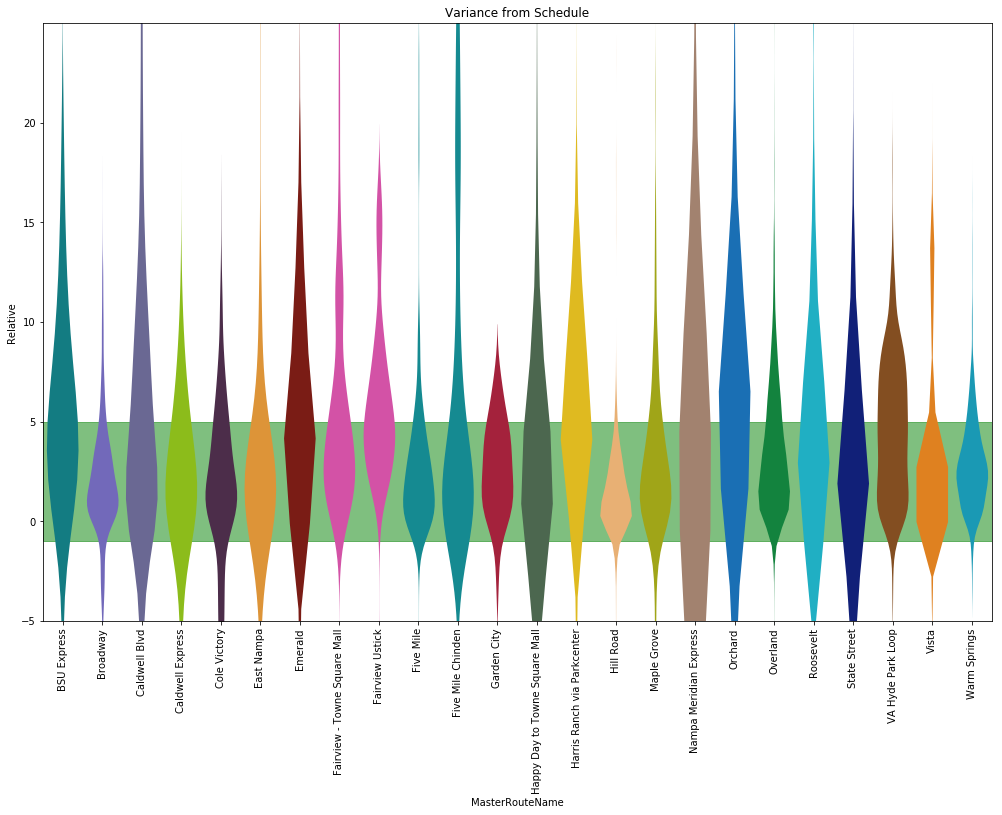

In [17]:
def violinPlot(data,level='MasterRouteName',save_file=None,early=-1,late=5,size=(17,11)):
    df=data
    df.sort_values(['MasterRouteName','TripName','StopOrder'],inplace=True)
    f,ax=plt.subplots(figsize=size)
    plt.axhspan(early,late,color='green',alpha=.5,zorder=0)
    plt.xticks(rotation=90)
    plt.yticks(np.arange(-5, 25, step=5))
    plt.ylim(-5,25)
    plt.ylabel("Minutes from Schedule")
    if level=='MasterRouteName':
        plot=sns.violinplot(x=df[level],y=df.Relative,ax=ax,scale='width',linewidth=0,palette=route_colors)
        plt.xlabel='Route'
    if level=='StopName':
        plot=sns.violinplot(x=df[level],y=df.Relative,ax=ax,scale='width',linewidth=0)
        plt.xlabel='Stop'
    plt.title("Variance from Schedule")
    plt.tight_layout
    if save_file:
        plot.figure.savefig(save_file)
    return plot
if (root.violin) & (root.route=='All'):
    violinPlot(df,save_file=save_file.format(save_name.format('violin'),".pdf"))
if (root.violin) & (root.route!='All'):
    violinPlot(df,save_file=save_file.format(save_name.format('{}_violin'.format(root.route)),".pdf"),level='StopName')

In [21]:
def Quantiler(data,RouteName,Stop,save_file=None):
    Stop_Quantiles=pd.DataFrame({'Route':[],
                             'StopName':[],
                             'ScheduledStopTime':[],
                             'Min':[],
                             'TenPercentQuant':[],
                             'TwentyFivePercentQuant':[],
                             'FiftyPercentQuant':[],
                             'SeventyFivePercentQuant':[],
                             'NinetyPercentQuant':[],
                             'Max':[],
                                'Range':[],
                                'Mid80':[]})
    cols=Stop_Quantiles.columns
    route=data.loc[data['MasterRouteName']==RouteName]
    route=route.sort_values(['ScheduledTripStart','StopOrder'])
    route['TravelTime']=route.DepartTime.diff()
    route.loc[route.ScheduledTripStart!=route.ScheduledTripStart.shift(1),'TravelTime']=None
    route['TravelDec']=(route.TravelTime.dt.total_seconds())/60
    route.loc[route.TravelDec<=0,'TravelDec']=None
    route.loc[route.TravelDec>100,'TravelDec']=None
    route_stop=route.loc[route['StopName']==Stop]
    for i in route_stop['time'].unique():
        time=route_stop.loc[route_stop['time']==i]
        Route=time['MasterRouteName'].iloc[0]
        StopName=time['StopName'].iloc[0]
        ScheduledStopTime=i
        Min=time['TravelDec'].min()
        TenPercentQuant=time['TravelDec'].quantile(q=.1)
        TwentyFivePercentQuant=time['TravelDec'].quantile(q=.25)
        FiftyPercentQuant=time['TravelDec'].quantile(q=.5)
        SeventyFivePercentQuant=time['TravelDec'].quantile(q=.75)
        NinetyPercentQuant=time['TravelDec'].quantile(q=.9)
        Max=time['TravelDec'].max()
        Range=Max-Min
        Mid80=NinetyPercentQuant-TenPercentQuant
        time_Quantiles=pd.DataFrame({'Route':[Route],
                                     'StopName':[StopName],
                                     'ScheduledStopTime':[ScheduledStopTime],
                                     'Min':[round(Min,1)],
                                     'TenPercentQuant':[round(TenPercentQuant,1)],
                                     'TwentyFivePercentQuant':[round(TwentyFivePercentQuant,1)],
                                     'FiftyPercentQuant':[round(FiftyPercentQuant,1)],
                                     'SeventyFivePercentQuant':[round(SeventyFivePercentQuant,1)],
                                     'NinetyPercentQuant':[round(NinetyPercentQuant,1)],
                                     'Max':[round(Max,1)],
                                     'Range':[round(Range,1)],
                                     'Mid80':[round(Mid80,1)]
                                    })
        Stop_Quantiles=Stop_Quantiles.append(time_Quantiles)
    Stop_Quantiles=Stop_Quantiles[cols]
    Stop_Quantiles.sort_values('ScheduledStopTime',inplace=True)
    if save_file:
        Stop_Quantiles.to_excel(save_file,index=False)
    return Stop_Quantiles
if root.quantiles:
    df=cleanOTPData(root.otp)
    if root.route!='All':
        df=filterData(df,root.route)
    df=getRelativeTimes(df)
    df=getDatesTimes(df)
    if root.route!='All':
        if second.stop!='All':
            Quantiler(df,root.route,second.stop,save_file=save_file.format(save_name.format('{}_{}_quantiles'.format(root.route,second.stop)),".xlsx"))
        else:
            for i in df.StopName.unique():
                Quantiler(df,root.route,i,save_file=save_file.format(save_name.format('{}_{}_quantiles'.format(root.route,i)),".xlsx"))
    else:
        for i in df.MasterRouteName.unique():
            df2=filterData(df,i)
            for j in df2.StopName.unique():
                Quantiler(df2,i,j,save_file=save_file.format(save_name.format('{}_{}_quantiles'.format(i,j)),".xlsx"))
